In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [26]:
df = pd.read_csv("data/my_horizon_data.csv")

In [27]:
df.head()

,subject,block,m1,m2,uc,gameLength,age,gender,trial,reward,...,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7,rt8,rt9
0,1001.0,0,40,32,1,1,26,0,0,51,...,-99.0,-99.0,-99.0,-99.0,0.416998,NaN,NaN,NaN,NaN,NaN
1,1001.0,1,60,48,1,1,26,0,0,52,...,-99.0,-99.0,-99.0,-99.0,0.317264,NaN,NaN,NaN,NaN,NaN
2,1001.0,2,40,20,-1,1,26,0,0,49,...,-99.0,-99.0,-99.0,-99.0,0.383654,NaN,NaN,NaN,NaN,NaN
3,1001.0,3,36,40,0,1,26,0,0,32,...,-99.0,-99.0,-99.0,-99.0,1.367162,NaN,NaN,NaN,NaN,NaN
4,1001.0,4,60,52,1,1,26,0,0,52,...,-99.0,-99.0,-99.0,-99.0,0.267352,NaN,NaN,NaN,NaN,NaN


In [28]:
num_subjects = df["subject"].nunique()
print("Number of unique subjects:", num_subjects)

Number of unique subjects: 610


In [ ]:
# same as sklearn 

seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

# only keep the first trial per subject
print(f"Original df shape: {df.shape}")
df = df.groupby('subject').head(1).reset_index(drop=True)
print(f"New df shape: {df.shape}")

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]

print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)



# X_seq_train = X_seq_train.to_numpy()
# X_seq_test = X_seq_test.to_numpy()
# X_static_train = X_static_train.to_numpy()
# X_static_test = X_static_test.to_numpy()

print("After scaling:")
print(f'X_seq_train {X_seq_train[0]}')
print(f'X_static_train {X_static_train[0]}')
print(f'y_train {y_train.iloc[0]}')

Original df shape: (98362, 44)
New df shape: (610, 44)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  51.0  0.0  47.0  1.0  33.0  1.0  18.0  1.0
1  51.0  0.0  47.0  1.0  33.0  1.0  18.0  1.0
2  51.0  0.0  47.0  1.0  33.0  1.0  18.0  1.0
3  51.0  0.0  47.0  1.0  33.0  1.0  18.0  1.0
4  51.0  0.0  47.0  1.0  33.0  1.0  18.0  1.0
   gameLength  uc
0           1   1
1           1   1
2           1   1
3           1   1
4           1   1

--- Target Data (y) ---
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: c4, dtype: float64
After scaling:
X_seq_train [ 0.41047858  0.9918366   1.49963376 -1.34335316  0.26195108  0.62792174
  0.68400015  1.01653005]
X_static_train [0.86189161 0.91379511]
y_train 0.0


In [5]:
SEQ_LEN = seq_features.__len__() // 4 
print(f"SEQ_LEN: {SEQ_LEN}")

SEQ_LEN: 2


In [6]:
feature_order_test = np.array(seq_features).reshape(-1, 4, SEQ_LEN)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [25]:
print(X_seq_train.shape)
print(X_seq_test.shape)
print(type(X_seq_train))
print(type(y_train))

(488, 4, 2)
(122, 4, 2)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [8]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, SEQ_LEN)
print(X_seq_test.shape)
print(type(X_seq_test))

(488, 4, 2)
<class 'numpy.ndarray'>
[[ 0.41047858  0.9918366 ]
 [ 1.49963376 -1.34335316]
 [ 0.26195108  0.62792174]
 [ 0.68400015  1.01653005]]
(122, 4, 2)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [9]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [10]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [11]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [12]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [13]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [14]:
class RNN(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, output_size=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(seq_input_size, hidden_size, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, h_n = self.rnn(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output


In [15]:
class LSTM(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=128, output_size=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 64), # combine static inputs
            nn.GELU(),
            nn.Linear(64, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        rnn_out, (h_n, c_n) = self.lstm(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate RNN output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [16]:
class GRU(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=64, output_size=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 32), # combine static inputs
            nn.ReLU(),
            nn.Linear(32, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

In [17]:
class TinyGRU(nn.Module):
    def __init__(self, seq_input_size=SEQ_LEN, static_input_size=2, hidden_size=2, output_size=2):
        super(TinyGRU, self).__init__()
        self.gru = nn.GRU(seq_input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size + static_input_size, 2), # combine static inputs
            nn.ReLU(),
            nn.Linear(2, output_size), # output layer
        )

    def forward(self, seq_x, static_x):
        gru_out, h_n = self.gru(seq_x)
        h_n = h_n.squeeze(0)
        # concatenate GRU output with static features
        combined = torch.cat((h_n, static_x), dim=1)
        output = self.fc(combined)
        return output

# train / eval

In [18]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for seq_inputs, static_inputs, labels in train_loader:
        seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(seq_inputs, static_inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for seq_inputs, static_inputs, labels in test_loader:
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            preds = model(seq_inputs, static_inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [19]:
model = TinyGRU().to(device)
print(model)

TinyGRU(
  (gru): GRU(2, 2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=4, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=2, bias=True)
  )
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

Epoch 1: Loss: 0.6908 | overall: 0.5164 | H1 0.6786 | H6 0.3788
Epoch 2: Loss: 0.6819 | overall: 0.5164 | H1 0.6786 | H6 0.3788
Epoch 3: Loss: 0.6775 | overall: 0.5164 | H1 0.6786 | H6 0.3788
Epoch 4: Loss: 0.6829 | overall: 0.5574 | H1 0.6786 | H6 0.4545
Epoch 5: Loss: 0.6740 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 6: Loss: 0.6742 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 7: Loss: 0.6714 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 8: Loss: 0.6708 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 9: Loss: 0.6690 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 10: Loss: 0.6653 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 11: Loss: 0.6651 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 12: Loss: 0.6620 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 13: Loss: 0.6633 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 14: Loss: 0.6638 | overall: 0.6803 | H1 0.6786 | H6 0.6818
Epoch 15: Loss: 0.6553 | overall: 0.6721 | H1 0.6786 | H6 0.6667
Epoch 16: Loss: 0.6627 | overall: 

In [22]:
import matplotlib.pyplot as plt

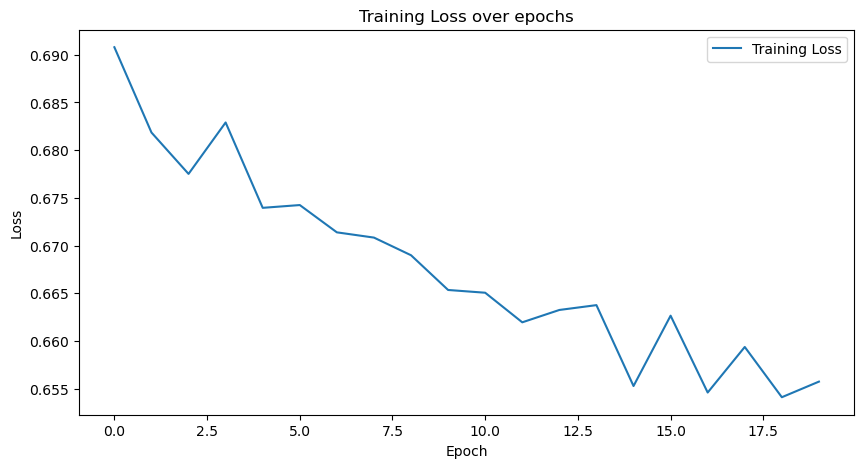

In [22]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

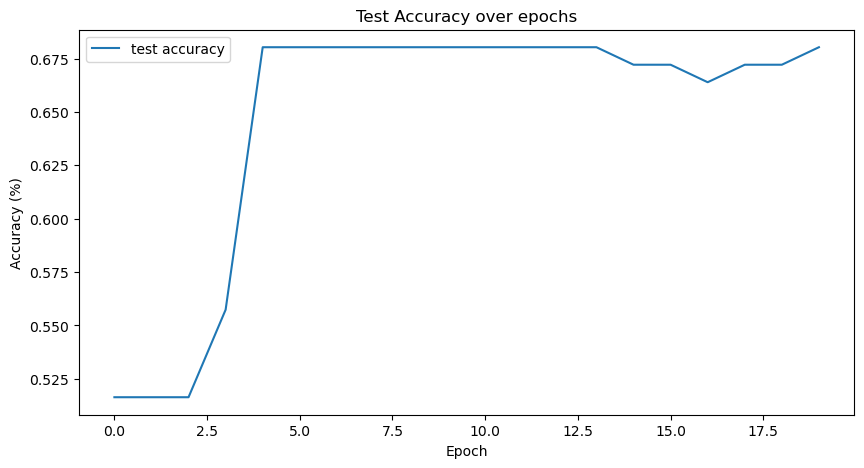

In [23]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

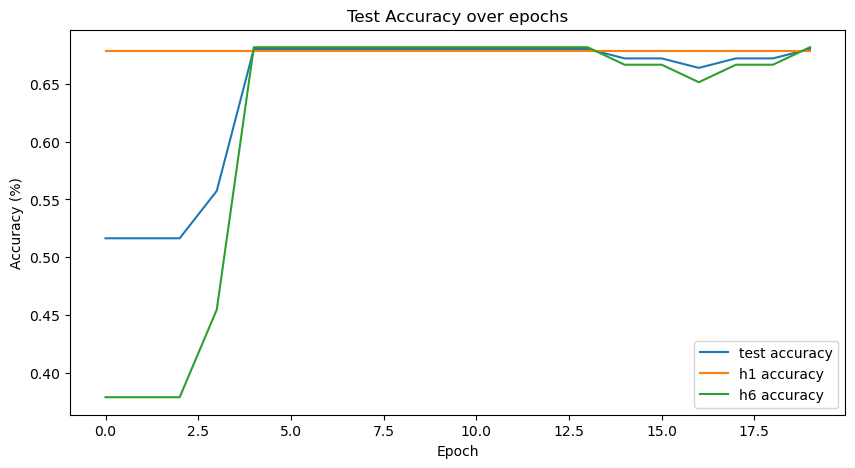

In [24]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])